# Plot some Survival curves


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LogNorm
#import scipy.sparse.linalg as sla

from scipy.integrate import odeint


sns.set_context("talk", font_scale=1.4)

from lifelines import KaplanMeierFitter




In [2]:
# load the inferred transition matrix
P_allCountries_Bayes = np.genfromtxt('./../results/transitionBayesAllCountries.csv')

### Simulation of Markov chains

In [6]:
# function for computing hitting times of random walks
def computeHittingTime(transitionMatrix,initialCondition,hittingTarget,rel):
    
    n=transitionMatrix.shape[0] # number of states
    
    hittingTimes = np.zeros(rel)
    
    # go over realisations
    for r in np.arange(rel):
        t=0
        oldstate = initialCondition # we start at the initial condition
        while ((oldstate in hittingTarget) == False):
            t=t+1
            newstate = np.random.choice(np.arange(n), p=transitionMatrix[oldstate,:])
            oldstate = newstate
        # save the number of steps needed
        hittingTimes[r] = t
    return(hittingTimes)  

In [7]:
# time until democracy (i.e., hitting time from -10 to >0)
hTimesDemocracy = computeHittingTime(P_allCountries_Bayes,0,np.arange(10,22),10**5)

In [8]:
# life time of democracy (i.e., hitting time from full democracy to <0)
hTimesAutocracy = computeHittingTime(P_allCountries_Bayes,20,np.arange(0,10),10**5)

# plotting survival curves

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(hTimesDemocracy,label='survival autocracies') 

kmf_Autocracy = KaplanMeierFitter()
kmf_Autocracy.fit(hTimesAutocracy,label='survival democracies') 

<lifelines.KaplanMeierFitter:"survival democracies", fitted with 100000 total observations, 0 right-censored observations>

In [10]:
tVec = np.arange(0,2000)
survivalFunctionDemocracy = kmf_Autocracy.survival_function_at_times(times=tVec)
survivalFunctionAutocracy = kmf.survival_function_at_times(times=tVec)

In [16]:
# Load the time series for plotting empirical distributions
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')
# do some cleaning
timeSeriesClean = timeSeries.dropna(subset=['year', 'country', 'polity2'])

In [17]:
# get certain countries
def getCountryTimeSeries(data,countryName):
    timeSeriesCountry = data[data['country'] == countryName]
    return(timeSeriesCountry)

def getLengthDemocracy(data,countryName):
    countryData = getCountryTimeSeries(data,countryName)
    temp = (countryData['polity2']>=0).values
    regimeLengths = np.diff(np.where(np.concatenate(([temp[0]],temp[:-1] != temp[1:],[True])))[0])[::2]
    return(regimeLengths)

def getLengthAutocracy(data,countryName):
    countryData = getCountryTimeSeries(data,countryName)
    temp = (countryData['polity2']<=0).values
    regimeLengths = np.diff(np.where(np.concatenate(([temp[0]],temp[:-1] != temp[1:],[True])))[0])[::2]
    return(regimeLengths)



In [18]:
franceDemocracyLength = getLengthDemocracy(timeSeriesClean,'France')[-1]
usDemocracyLength = getLengthDemocracy(timeSeriesClean,'United States')[-1]

brazilDemocracyLength = getLengthDemocracy(timeSeriesClean,'Brazil')[-1]
northKoreaAutocracyLength = getLengthAutocracy(timeSeriesClean,'Korea North')[-1]

egyptAutocracyLength = getLengthAutocracy(timeSeriesClean,'Egypt')[-1]


belarusAutocracyLength = getLengthAutocracy(timeSeriesClean,'Belarus')[-1]


#russiaAutocracyLength = getLengthAutocracy(timeSeriesClean,'Russia')[-1]



/opt/anaconda3/envs/networkScience/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


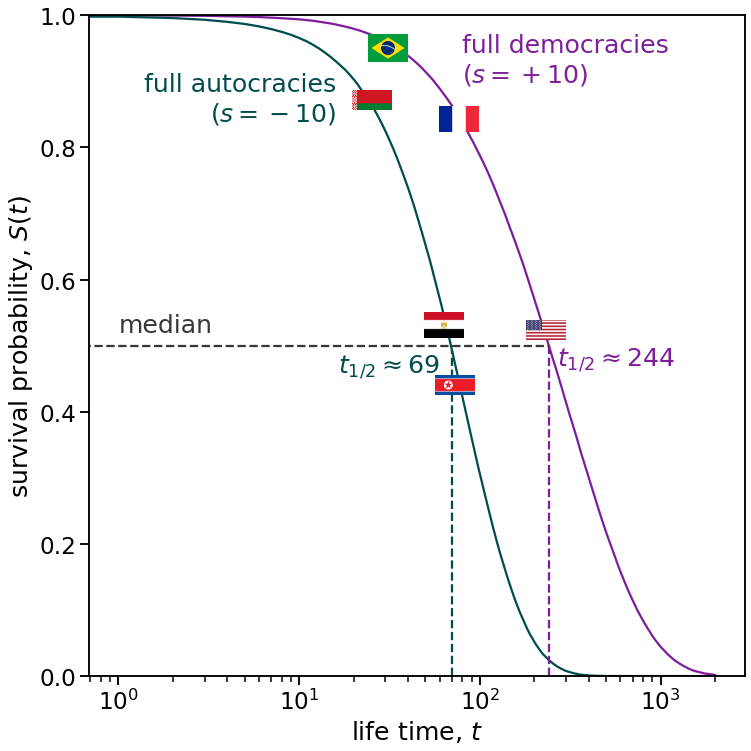

In [23]:
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(1, 1, 1)
plt.plot(survivalFunctionDemocracy,color=sns.xkcd_rgb['purple'])
plt.plot(survivalFunctionAutocracy,color=sns.xkcd_rgb['dark teal'])
ax.set_xscale('log')

plt.text(x=16,y=0.84,s=r'full autocracies' '\n' '($s=-10$)',color=sns.xkcd_rgb['dark teal'],ha='right')
plt.text(x=80,y=0.9,s=r'full democracies' '\n' '($s=+10$)',color=sns.xkcd_rgb['purple'])

# insert median survival 
medianSurvivalDemocracy =  np.where(survivalFunctionDemocracy<0.5)[0][0]
medianSurvivalAutocracy =  np.where(survivalFunctionAutocracy<0.5)[0][0]

plt.plot([medianSurvivalDemocracy,medianSurvivalDemocracy],[0,survivalFunctionDemocracy[medianSurvivalDemocracy]],linestyle='--',color=sns.xkcd_rgb['purple'])
plt.plot([medianSurvivalAutocracy,medianSurvivalAutocracy],[0,survivalFunctionAutocracy[medianSurvivalAutocracy]],linestyle='--',color=sns.xkcd_rgb['dark teal'])
plt.plot([0,medianSurvivalDemocracy],[0.5,0.5],linestyle='--',color=sns.xkcd_rgb['dark grey'])

plt.text(1,0.52, r'median',color=sns.xkcd_rgb['dark grey'])

plt.text(267,0.47, r'$t_{1/2}\approx 244$',color=sns.xkcd_rgb['purple'])
plt.text(60,0.46, r'$t_{1/2}\approx 69$',color=sns.xkcd_rgb['dark teal'],ha='right')
plt.ylim([0,1])


plt.xlabel('life time, $t$')
plt.ylabel('survival probability, $S(t)$')

# insert flags
def insertFlag(fileName,position):
    im = plt.imread(fileName)
    newax = fig.add_axes(position, anchor='NE', zorder=+1)
    newax.imshow(im)
    newax.axis('off')



# these vlines are used to find the flag positions manually
#plt.vlines(x=belarusAutocracyLength,ymin=0,ymax=1)

# Democracies
insertFlag(fileName='./../data/flags/800px-Flag_of_the_United_States.png',position=[0.69, 0.52, 0.05, 0.05])
insertFlag(fileName='./../data/flags/Flag_of_France.png',position=[0.58, 0.79, 0.05, 0.05])
insertFlag(fileName='./../data/flags/Flag_of_Brazil.svg.png',position=[0.49, 0.88, 0.05, 0.05])

# Autocracies
insertFlag(fileName='./../data/flags/Flag_of_North_Korea.svg.png',position=[0.575, 0.45, 0.05, 0.05])
insertFlag(fileName='./../data/flags/Flag_of_Egypt.svg.png',position=[0.56, 0.53, 0.05, 0.05])
insertFlag(fileName='./../data/flags/Flag_of_Belarus.svg.png',position=[0.47, 0.81, 0.05, 0.05])






fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('./../results/figures/Fig6-survivalCurves.pdf')


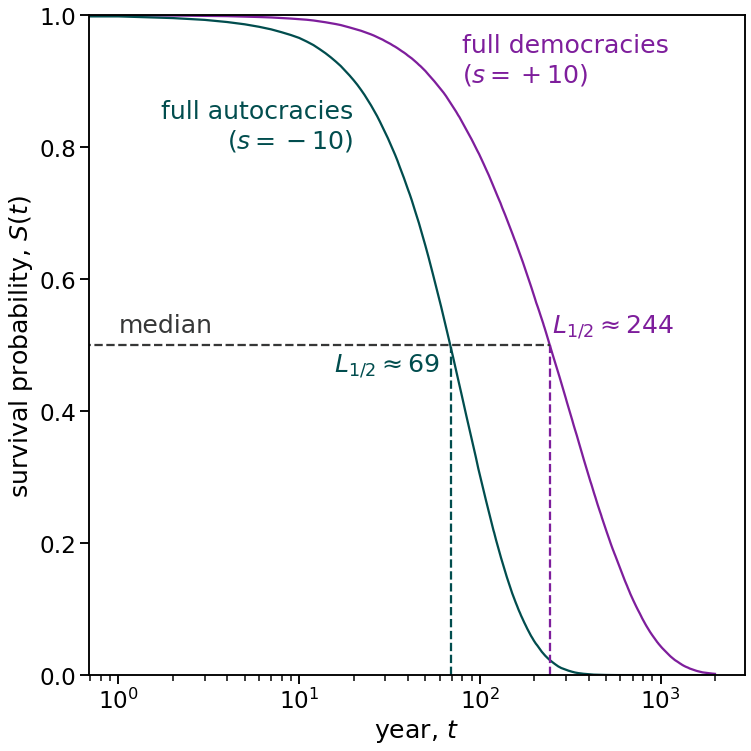

In [122]:
# fig = plt.figure(figsize=(11,11))
# ax = fig.add_subplot(1, 1, 1)
# plt.plot(survivalFunctionDemocracy,color=sns.xkcd_rgb['purple'])
# plt.plot(survivalFunctionAutocracy,color=sns.xkcd_rgb['dark teal'])
# ax.set_xscale('log')

# #plt.text(x=1,y=0.8,s=r'full autocracies ($s=-10$)',color=sns.xkcd_rgb['green'])
# plt.text(x=20,y=0.8,s=r'full autocracies' '\n' '($s=-10$)',color=sns.xkcd_rgb['dark teal'],ha='right')
# plt.text(x=80,y=0.9,s=r'full democracies' '\n' '($s=+10$)',color=sns.xkcd_rgb['purple'])

# # insert median survival 
# medianSurvivalDemocracy =  np.where(survivalFunctionDemocracy<0.5)[0][0]
# medianSurvivalAutocracy =  np.where(survivalFunctionAutocracy<0.5)[0][0]

# plt.plot([medianSurvivalDemocracy,medianSurvivalDemocracy],[0,survivalFunctionDemocracy[medianSurvivalDemocracy]],linestyle='--',color=sns.xkcd_rgb['purple'])
# plt.plot([medianSurvivalAutocracy,medianSurvivalAutocracy],[0,survivalFunctionAutocracy[medianSurvivalAutocracy]],linestyle='--',color=sns.xkcd_rgb['dark teal'])
# plt.plot([0,medianSurvivalDemocracy],[0.5,0.5],linestyle='--',color=sns.xkcd_rgb['dark grey'])

# plt.text(1,0.52, r'median',color=sns.xkcd_rgb['dark grey'])

# plt.text(250,0.52, r'$L_{1/2}\approx 244$',color=sns.xkcd_rgb['purple'])
# plt.text(60,0.46, r'$L_{1/2}\approx 69$',color=sns.xkcd_rgb['dark teal'],ha='right')
# plt.ylim([0,1])

# plt.xlabel('year, $t$')
# plt.ylabel('survival probability, $S(t)$')

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('./figures/survivalCurveRegimes.pdf')

In [14]:
medianSurvivalDemocracy =  np.where(survivalFunctionDemocracy<0.5)[0][0]
medianSurvivalAutocracy =  np.where(survivalFunctionAutocracy<0.5)[0][0]

In [15]:
medianSurvivalDemocracy

243

In [16]:
medianSurvivalAutocracy

69

In [123]:
democracy001 =  np.where(survivalFunctionDemocracy<0.01)[0][0]
autocracy001 =  np.where(survivalFunctionAutocracy<0.01)[0][0]

In [124]:
democracy001

1450

In [125]:
autocracy001

287

### Standard deviations

In [24]:
np.std(hTimesDemocracy)

61.554454640033164

In [25]:
np.std(hTimesAutocracy)

310.256849520842

In [26]:
np.median(hTimesDemocracy)

69.0

In [27]:
np.median(hTimesAutocracy)

243.0

In [28]:
np.mean(hTimesDemocracy)

83.77791

In [29]:
np.mean(hTimesAutocracy)

336.50504